# Developing Heart Failure Risk Score for Diabetic Patients by Deep Learning from Electronic Health Records

<font size="3">Our goal is to develop and validate deep learning models for predicting incident heart failure (HF) events in patients with Diabetes mellitus (DM) using electronic health records (EHRs) data. Patients with diabetes are at increased risk for developing HF, leading to a tremendous personal health burden and substantial healthcare cost. Identifying patients with diabetes at highest risk for HF will enable delivery of personalized preventive treatment strategies to those individuals at greatest need.</font>



Cohort Extraction Description
-----------------------
We originally identified 3,668,780 patients with at least one encounter with an ICD code (ICD 9 / ICD-10-CA / ICD-10-CM) for diabetes or an associated diabetes complication out of which:

- 14,407 patients with Diabetes Insipidus [diagnosis_code in ( '253.5','E23.2','588.1','N25.1')), who we identified to exclude from our cohort in case those patients were incorrectly documented for DM within the EHR.]

- 80,237 patients with gestiginal(preganacy) or history of gestiginal DM [ICD-9 '648%', ICD-10 like 'O24%' or in ('Z86.32', 'V12.21')]
- 30,182 Neonatal DM patients or infant of Diabetic Mother [ICD-9 '775%' /ICD-10 'P70%']
- 49,848 Patients with Secondary DM [ICD-9 like '249%' or ICD-10 like 'E08%' or 'E09%' ]
- 304,949 with Type I DM [ICD-10 like E10%' or ICD-9 in ('250.01','250.03','250.13','250.81','250.61','250.41','250.63',
'250.51','250.83','250.11','250.43','250.93','250.53','250.91','250.71','250.21','250.73','250.23','250.33','250.31')]

We decided to exclude the above patients from our cohort as we will focus on patients with type II DM and need to avoid any chance of wrong coding considering that most of the EHR data are based on user manual enteries and there is a high associated chance of data entry mistakes. For the same reason we decided to include patients that have more than encounter with a diabetes diagnosis code, hence we excluded 1,650,736 patients who only showed 1 encounter with a diabetes diagnosis.

For Cases, we identified patient with incidences of heart failure [using ICD-9_codes like '428%' in ('404.03','404.13','402.11','404.11','402.01','404.01','402.91','398.91','404.93','404.91') or ICD-10 codes like 'I50%' or in ('I11.0','I09.81','I13.2','I97.13','I97.131','I13.0','I97.130')]

we identified 587,906 patients from the original cohort reported HF along with DM, among which:
    - 90,856 patients reported HF before DM.
    - 226,589 patients reported HF on the same day as DM.
    - 268,080 patients reported HF after DM encounter discharge 

We applied all exclusion criteria described for DM on those 268,080 patients, and for a more conservetive definition of our cases we selected patients who reported HF at least 30 days after their first encounter with a type II DM code. we also excluded patients with only one HF encounter for quality. 

Further data cleaning, include exclusion of patients with incorrect or incomplete data, for example patients who were recorded as expired in between their first encounter and our event (first HF encounter for caases or last encounter for controls)

Our Final cohort include 72,552 cases and 1,123,074 Controls

Cerner HealthFacts v.2017 includes 17,629 ICD9 codes,  94,044 ICD10-CM and 16,044 ICD10-CA, as well as 3,385 unique medication generic name, Our cohort uses around 52,000 code out of which 50,000 are either ICD 9 or 10 codes and the rest are medication generic names.

#### Required Tools and Packages
---------------------------------
We mostly use scikit-learn for baseline machine learning, plotly and matpoltlib for visualization within ipython notebooks, but we also use Tableau aside of it.

For baseline survival analysis we used the lifelines package, and hence we used the compatabile matplotlib (2.2) and pandas (1.8) versions.

For deep learning we rely on Pytorch framework (v1), GPU enabling accelerate the computational performance,and for the full set model trainings we might need to utilize the Pytorch DataParallel functionality for parallel GPU computing. 

In [31]:
### Tools and Packages
##Basics
import pandas as pd
import numpy as np
import sys, random
import math
try:
    import cPickle as pickle
except:
    import pickle
import string
import re
import os
import time


## ML and Stats 
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import sklearn.metrics as m
import sklearn.linear_model  as lm
import lifelines as ll #for survival analysis
from lifelines.estimation import KaplanMeierFitter
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.tree import export_graphviz
import statsmodels.formula.api as sm
import patsy
from scipy import stats

## Visualization
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
%matplotlib inline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.plotly as py
import plotly.tools as tls
import plotly.graph_objs as go
from plotly.graph_objs import *
from IPython.display import HTML

## DL Framework
import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim



###GPU enabling and device allocation
use_cuda = torch.cuda.is_available()
torch.cuda.set_device(0)



## Cohort Description

In [2]:
Filename="/data/projects/Diab_HF/Data/cohort_demo_cl1.tsv"
cohort_demo_df= pd.read_csv(Filename,sep='\t')

In [3]:
## Patients Demographics
### Primary Exploration
cohort_demo_df.sample(10)

,PATIENT_SK,RACE_CAT,GENDER_CAT,MARITAL_CAT,MIN_AGE,LABEL
722745,175407492,White,Female,Partner,58,Ctrl
248863,122855884,White,Male,Unknown,74,Ctrl
615847,149623497,African_American,Male,Single,52,Ctrl
361311,130392862,White,Male,Partner,86,Ctrl
1000743,214551447,White,Male,Single,49,Ctrl
629849,150524368,African_American,Female,Single,57,Ctrl
231371,121146566,White,Male,Single,56,Ctrl
1169766,326191593,White,Female,Partner,35,Ctrl
798594,187670733,White,Female,Partner,37,Ctrl
209201,118183999,White,Male,Single,55,Ctrl


In [4]:
#### Basic Summary Statistics
### Primary Exploration
SumC=cohort_demo_df['LABEL'].value_counts()
summNcg=cohort_demo_df['GENDER_CAT'].groupby(cohort_demo_df['LABEL']).value_counts(normalize=True)
summNcr=cohort_demo_df['RACE_CAT'].groupby(cohort_demo_df['LABEL']).value_counts(normalize=True)
summNcm=cohort_demo_df['MARITAL_CAT'].groupby(cohort_demo_df['LABEL']).value_counts(normalize=True)
summN=cohort_demo_df[['RACE_CAT' ,'GENDER_CAT','MARITAL_CAT']].groupby(cohort_demo_df['LABEL']).describe()#.transpose()
summC=cohort_demo_df[['MIN_AGE']].groupby(cohort_demo_df['LABEL']).describe().transpose()
print('Cohort: \n',SumC , '  \n','  \n')
print(summN , '  \n','  \n')
print('Different demographics distribution: \n', summNcg,'  \n' , summNcr,'  \n' ,summNcm,'  \n')
print(summC)

Cohort: 
 Ctrl    1123074
Case      72552
Name: LABEL, dtype: int64   
   

      RACE_CAT                       GENDER_CAT                         \
         count unique    top    freq      count unique     top    freq   
LABEL                                                                    
Case     72552      5  White   55476      72552      3  Female   36926   
Ctrl   1123074      5  White  787190    1123074      3  Female  596781   

      MARITAL_CAT                          
            count unique      top    freq  
LABEL                                      
Case        72552      4  Partner   31628  
Ctrl      1123074      4  Partner  566778     
   

Different demographics distribution: 
 LABEL  GENDER_CAT
Case   Female        0.508959
       Male          0.488987
       Unknown       0.002054
Ctrl   Female        0.531382
       Male          0.465497
       Unknown       0.003121
Name: GENDER_CAT, dtype: float64   
 LABEL  RACE_CAT        
Case   White               

In [45]:
### OLS Regression
cohort_demo_df.loc[cohort_demo_df["LABEL"] == "Case", "LABEL"] = 1
cohort_demo_df.loc[cohort_demo_df["LABEL"] == "Ctrl", "LABEL"] = 0
f = 'LABEL ~ RACE_CAT + GENDER_CAT + MARITAL_CAT+MIN_AGE'
#y,X = patsy.dmatrices(f, cohort_demo_df, return_type='dataframe')
print(sm.logit(formula=f,data=cohort_demo_df).fit().summary())

/home/lgindybekhet/.local/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



Optimization terminated successfully.
         Current function value: 0.213256
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  LABEL   No. Observations:              1195626
Model:                          Logit   Df Residuals:                  1195615
Method:                           MLE   Df Model:                           10
Date:                Thu, 31 Jan 2019   Pseudo R-squ.:                 0.06809
Time:                        15:14:06   Log-Likelihood:            -2.5497e+05
converged:                       True   LL-Null:                   -2.7360e+05
                                        LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -6.0592      0.024   -248.076      0.000      -6.

## Descriptive Survival Analysis

          removed  observed  censored  entrance  at_risk  survival prob
event_at                                                               
92           1024       103       921         0  1095122       0.993659
735           747        43       704         0   710034       0.956081
807           498        29       469         0   672076       0.952719
984           391        23       368         0   586338       0.944945
1247          449        20       429         0   470251       0.933400
1253          548        38       510         0   467934       0.933139
1389          353        23       330         0   414469       0.927279
1556          334        19       315         0   353142       0.920190
2097          223         6       217         0   181175       0.897966
2407          166         2       164         0   118706       0.886367
2596          176         7       169         0    89582       0.878890
2776          149         2       147         0    60311       0

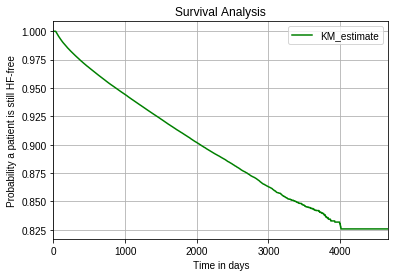

In [5]:
##Data Preparation
sedata = pd.read_csv('/data/projects/Diab_HF/Data/timefromDiabtoHF_cl1.tsv', sep = '\t')
#slicing the control with longest duration to HF 
sdata = sedata.sort_values(['TIME_TO_HF'], ascending=True).groupby(['PATIENT_SK']).tail(1)
#change label to binary variable
sdata.loc[sdata["LABEL"] == "Case", "LABEL"] = 1
sdata.loc[sdata["LABEL"] == "Ctrl", "LABEL"] = 0

#remove patient who has TIME_TO_HF > 5000 (outliers)
sdata  = sdata[sdata['TIME_TO_HF']<=5000]

## Model initiation
kmf = KaplanMeierFitter()
#KM table
T = sdata['TIME_TO_HF']
C = sdata['LABEL']
kmf.fit(T, event_observed=C)
table = kmf.event_table
table['survival prob'] = kmf.survival_function_

# show life table (function), if possible
print(table.sample(n=20).sort_values(by='event_at'))

##PLotting the survival function 
kmf.survival_function_.plot(title='Survival Analysis', color = 'green')
plt.style.use('seaborn-ticks')
plt.ylabel("Probability a patient is still HF-free")
plt.xlabel('Time in days')
plt.grid(True)
plt.show()

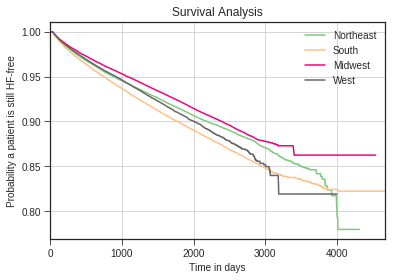

In [7]:
### Survival for different subgroups
def sub_survival_analysis(data, covar, value_list=''):
    '''
    data: the data source
    covar (string): the column name from which subgroup will be extracted.
    value_list (list or ''): list of value in the column for subgroup extraction. 
                            If not specified, analysis will be done on all subgroups. 
    '''
    if value_list =='': value_list = data[covar].unique()
    ax = plt.subplot(111)
    plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Accent(np.linspace(0,1,len(value_list)))))
    for name in value_list:
        idx = data[covar]==name
        T = data[idx]['TIME_TO_HF']
        C = data[idx]['LABEL']
        kmf.fit(T,C,label=name)
        kmf.survival_function_.plot(title='Survival Analysis', ax=ax)
        plt.ylabel('Probability a patient is still HF-free')
        plt.xlabel('Time in days')
        plt.grid(True)
    plt.show()
    
sub_survival_analysis(sdata, 'CENSUS_REGION') 

# Baseline Analysis

## Rationale

The goal of this analaysis is to explore the chararistics of the data. We use logistic regression and RNN for the prediction of case/control labels. For simplicity, we only used randomly selected 30% of our cases and doubled the count for random controls selection. We explored the performance of the data collected before the onset of diabetes and theose collected afterwards. As described in the cohort extraction we excluded cases who developed HF within 30 days of their first DM encounter. The analysis plan for the full project is described in the proposal. 


#### Data Loading and Preparation

In [8]:
### A random sample of 25,000 case and 50,000 control were selected for a primary analysis 
### which are further subdivided into training validation and testing sets
## processed Data Loading 
##### PreDiab
train_sl_pre= pickle.load(open('/data/projects/Diab_HF/pdata/dhf_prediab_sample_cl1.combined.train', 'rb'), encoding='bytes')
test_sl_pre= pickle.load(open('/data/projects/Diab_HF/pdata/dhf_prediab_sample_cl1.combined.test', 'rb'), encoding='bytes')
valid_sl_pre= pickle.load(open('/data/projects/Diab_HF/pdata/dhf_prediab_sample_cl1.combined.valid', 'rb'), encoding='bytes')
#### PostDiab
train_sl_post= pickle.load(open('/data/projects/Diab_HF/pdata/dhf_postdiab_samesample_cl1.combined.train', 'rb'), encoding='bytes')
test_sl_post= pickle.load(open('/data/projects/Diab_HF/pdata/dhf_postdiab_samesample_cl1.combined.test', 'rb'), encoding='bytes')
valid_sl_post= pickle.load(open('/data/projects/Diab_HF/pdata/dhf_postdiab_samesample_cl1.combined.valid', 'rb'), encoding='bytes')
### Our current data include around 52K feature mainly ICD 9 and 10 codes for diagosis and Medication generic name
### We plan to add other variables like procdeures , surgery , other clincial events including vital signs measurements  and lab tests and results
input_size_1=[52007]
# types dictionary
types_d=pickle.load(open('/data/projects/Diab_HF/pdata/dhf_prepostdiab_samesample.types', 'rb'), encoding='bytes')
types_d_rev = dict(zip(types_d.values(),types_d.keys()))

print (len(train_sl_pre),len(valid_sl_pre),len(test_sl_pre))
print (len(train_sl_post),len(valid_sl_post),len(test_sl_post)) ### numbers should match they are the same subset of patients

52500 7500 15000
52500 7500 15000


In [9]:
##### Data conversion to onehot matrices for Logestic Regression and may be Random Forest Basic test
pts_tr_pre=[]
labels_tr_pre=[]
features_tr_pre=[]
for pt in train_sl_pre:
    pts_tr_pre.append(pt[0])
    labels_tr_pre.append(pt[1])
    x=[]
    for v in pt[-1]:
        x.extend(v[-1])
    features_tr_pre.append(x)
      
pts_t_pre=[]
labels_t_pre=[]
features_t_pre=[]
for pt in test_sl_pre:
    pts_t_pre.append(pt[0])
    labels_t_pre.append(pt[1])
    x=[]
    for v in pt[-1]:
        x.extend(v[-1])
    features_t_pre.append(x)
    
pts_tr_post=[]
labels_tr_post=[]
features_tr_post=[]
for pt in train_sl_post:
    pts_tr_post.append(pt[0])
    labels_tr_post.append(pt[1])
    x=[]
    for v in pt[-1]:
        x.extend(v[-1])
    features_tr_post.append(x)
      
pts_t_post=[]
labels_t_post=[]
features_t_post=[]
for pt in test_sl_post:
    pts_t_post.append(pt[0])
    labels_t_post.append(pt[1])
    x=[]
    for v in pt[-1]:
        x.extend(v[-1])
    features_t_post.append(x)
    
mlb = MultiLabelBinarizer(classes=range(52007)[1:])
nfeatures_tr_pre = mlb.fit_transform(features_tr_pre)
nfeatures_t_pre = mlb.fit_transform(features_t_pre)
nfeatures_tr_post = mlb.fit_transform(features_tr_post)
nfeatures_t_post = mlb.fit_transform(features_t_post)

In [15]:
### Model Evaluation
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    pred_prob=model.predict_proba(test_features)
    auc_p=roc_auc_score(test_labels,pred_prob[:,1])
    print('Model Performance')
    print('AUC = {:0.2f}%.'.format(auc_p*100))
    return test_labels,pred_prob[:,1]

In [16]:
### ROC curve plotting

def plot_roc_curve(label,score):
    fpr, tpr, ths = m.roc_curve(label, score) ### If I round it gives me an AUC of 64%
    roc_auc = m.auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',lw=3, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.ylabel('Sensitivity')
    plt.xlabel('1-Specificity')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()

In [39]:
#### Interactive Plot showing the deep learning model training AUC change over epochs

def plot_DLauc_perf(train_auc_allepv,test_auc_allepv,valid_auc_allepv,title_m):
    epochs=100
    train_auc_fg= go.Scatter(x= np.arange(epochs), y=train_auc_allepv, name='train')
    test_auc_fg= go.Scatter(x= np.arange(epochs), y=test_auc_allepv, name='test')
    valid_auc_fg= go.Scatter(x= np.arange(epochs), y=valid_auc_allepv, name='valid')
    valid_max = max(valid_auc_allepv)
    test_max = max(test_auc_allepv)
    data = [train_auc_fg,test_auc_fg,valid_auc_fg]
    layout = go.Layout(xaxis=dict(dtick=1),title=title_m)
    layout.update(dict(annotations=[go.layout.Annotation(text="Max Valid", x=valid_auc_allepv.index(valid_max), y=valid_max)]))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, filename=title_m)

In [18]:
### for tracking computational timing
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


In [46]:
### DL RNN Model training 

def run_dl_model(ehr_model,train_sl,valid_sl,test_sl):

    ##Hyperparameters -- Fixed for testing purpose
    epochs = 100
    l2 = 0.0001
    lr = 0.01
    eps = 1e-4
    w_model='RNN'
    optimizer = optim.Adamax(ehr_model.parameters(), lr=lr, weight_decay=l2 ,eps=eps)   

    ##Training epochs
    bestValidAuc = 0.0
    bestTestAuc = 0.0
    bestValidEpoch = 0
    train_auc_allep =[]
    valid_auc_allep =[]
    test_auc_allep=[]  
    for ep in range(epochs):
        start = time.time()
        current_loss, train_loss = TVT.train(train_sl, model= ehr_model, optimizer = optimizer, batch_size =128)
        avg_loss = np.mean(train_loss)
        train_time = timeSince(start)
        eval_start = time.time()
        Train_auc, y_real, y_hat  = TVT.calculate_auc(model = ehr_model, data = train_sl, which_model = w_model, batch_size = 128)
        valid_auc, y_real, y_hat  = TVT.calculate_auc(model = ehr_model, data = valid_sl, which_model = w_model, batch_size = 128)
        TestAuc, y_real, y_hat = TVT.calculate_auc(model = ehr_model, data = test_sl, which_model = w_model, batch_size = 128)
        eval_time = timeSince(eval_start)
        print ("Epoch: " ,str(ep) ," Train_auc :" , str(Train_auc) , " , Valid_auc : " ,str(valid_auc) , " ,& Test_auc : " , str(TestAuc) ," Avg Loss: " ,str(avg_loss), ' , Train Time :' , str(train_time) ,' ,Eval Time :' ,str(eval_time))
        train_auc_allep.append(Train_auc)
        valid_auc_allep.append(valid_auc)
        test_auc_allep.append(TestAuc)

        if valid_auc > bestValidAuc: 
            bestValidAuc = valid_auc
            bestValidEpoch = ep
            bestTestAuc = TestAuc
            ###uncomment the below lines to save the best model parameters
            #best_model = ehr_model
            #torch.save(best_model, bmodel_pth)
            #torch.save(best_model.state_dict(), bmodel_st)
        if ep - bestValidEpoch >5: break
    print( 'bestValidAuc %f has a TestAuc of %f at epoch %d ' % (bestValidAuc, bestTestAuc, bestValidEpoch))
    return train_auc_allep,valid_auc_allep,test_auc_allep

## PreDiabetes Data Analysis

### Logestic Regression

/home/lgindybekhet/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Model Performance
AUC = 72.40%.


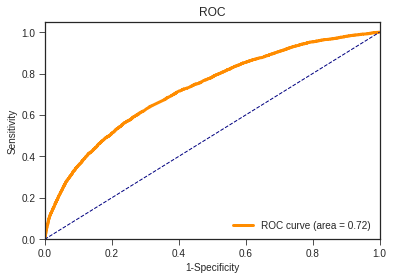

Highly contributing factors based on coefficients: 
5303 1.6154918555923936 b'D_1258'
6653 1.6366084021044716 b'D_2820'
8844 1.6748590987315148 b'D_8267'


In [20]:
EHR_LR= lm.LogisticRegression()
EHR_LR.fit(nfeatures_tr_pre, labels_tr_pre)
labels,scores=evaluate(EHR_LR,nfeatures_t_pre, labels_t_pre)

plot_roc_curve(labels,scores)

print ("Highly contributing factors based on coefficients: ")
f_imp=EHR_LR.coef_
## top contributing factors in both directions
for i,j in enumerate(f_imp[0].tolist()):
    if j>1.6:
        print (i+1,j,types_d_rev[i+1])


##### Variables appears above with highest positive coeffiecient
-------------------------------------------------
- D_1258	ICD9	425.9	"SECONDARY CARDIOMYOPATHY, UNSPECIFIED" 
- D_2820	ICD9	908.9	"LATE EFFECT OF UNSPECIFIED INJURY"
- D_8267	ICD9	588.9	"UNSPECIFIED DISORDER RESULTING FROM IMPAIRED RENAL FUNCTION"

### RNN

In [35]:
### Import the RNN model definition that include the definition of the embedding architucture and different variations of RNN architictures
### we will use a very basic GRU layer for this primary analysis
import model_HPS1 as model 
import TrVaTe as TVT 

ehr_model_pre = model.EHR_RNN(input_size_1, embed_dim=128, hidden_size=128, n_layers=1, dropout_r=0., cell_type='GRU', bii=False , time=True)
if use_cuda: ehr_model_pre = ehr_model_pre.cuda()    

### Model training 
train_auc_allep_pre,valid_auc_allep_pre,test_auc_allep_pre=run_dl_model(ehr_model_pre,train_sl_pre,valid_sl_pre,test_sl_pre)

Epoch:  0  Train_auc : 0.748381139305476  , Valid_auc :  0.7404184042956075  ,& Test_auc :  0.7356425470135468  Avg Loss:  0.5759486964563044  , Train Time : 1m 6s  ,Eval Time : 1m 31s
Epoch:  1  Train_auc : 0.7678629654485132  , Valid_auc :  0.7472550211300588  ,& Test_auc :  0.7422019249042715  Avg Loss:  0.5501027854477487  , Train Time : 1m 11s  ,Eval Time : 1m 36s
Epoch:  2  Train_auc : 0.7794203172674196  , Valid_auc :  0.7480287308615385  ,& Test_auc :  0.7445368112596971  Avg Loss:  0.5394932121038436  , Train Time : 1m 7s  ,Eval Time : 1m 28s
Epoch:  3  Train_auc : 0.7956460847209857  , Valid_auc :  0.7485176465842805  ,& Test_auc :  0.746777780297595  Avg Loss:  0.5309661528686197  , Train Time : 1m 2s  ,Eval Time : 1m 29s
Epoch:  4  Train_auc : 0.8055645333847179  , Valid_auc :  0.7456858729686668  ,& Test_auc :  0.7418699752452391  Avg Loss:  0.5209924276282147  , Train Time : 1m 7s  ,Eval Time : 1m 39s
Epoch:  5  Train_auc : 0.8248879365682026  , Valid_auc :  0.74438359163

In [40]:
#### Interactive Plot showing the model training AUC change over epochs
plot_DLauc_perf(train_auc_allep_pre,test_auc_allep_pre,valid_auc_allep_pre,'PreDiab_GRU_Auc')

## PostDiabetes Data Analysis

### Logestic Regression

/home/lgindybekhet/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Model Performance
AUC = 81.80%.


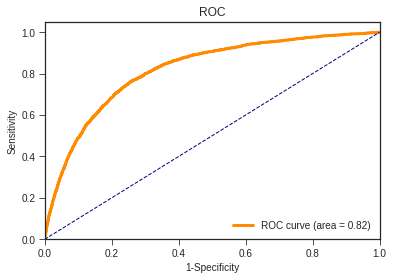

Highly contributing factors based on coefficients: 
6736 2.0976835040667003 b'D_16379'


In [34]:
EHR_LR_p= lm.LogisticRegression()
EHR_LR_p.fit(nfeatures_tr_post, labels_tr_post)
labels_ps,scores_ps=evaluate(EHR_LR_p,nfeatures_t_post, labels_t_post)

plot_roc_curve(labels_ps,scores_ps)

#### Will take that out
print ("Highly contributing factors based on coefficients: ")
f_imp=EHR_LR_p.coef_
## top contributing factors in both directions
for i,j in enumerate(f_imp[0].tolist()):
    if j>2:
        print (i+1,j,types_d_rev[i+1])


##### Variables appears above with highest positive coeffiecient
-------------------------------------------------
- D_16379	ICD9	429.83	"Takotsubo syndrome"


### RNN

In [ ]:
import model_HPS1 as model 
import TrVaTe as TVT 

ehr_model_post = model.EHR_RNN(input_size_1, embed_dim=128, hidden_size=128, n_layers=1, dropout_r=0., cell_type='GRU', bii=False , time=True)
if use_cuda: ehr_model_post = ehr_model_post.cuda()    

### Model training 
train_auc_allep_post,valid_auc_allep_post,test_auc_allep_post=run_dl_model(ehr_model_post,train_sl_post,valid_sl_post,test_sl_post)

In [42]:
#### Interactive Plot showing the model training AUC change over epochs
plot_DLauc_perf(train_auc_allep_post,test_auc_allep_post,valid_auc_allep_post,'PostDiab_GRU_Auc')